[原版（英文）图书地址](https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/)

**翻译**：[apachecn](https://github.com/apachecn)，[翻译版本地址](https://github.com/apachecn/feature-engineering-for-ml-zh)

**代码修改和整理**：[黄海广](https://github.com/fengdu78)，原文修改成jupyter notebook格式，并增加和修改了部分代码，测试全部通过，所有数据集已经放在[百度云](data/README.md)下载。

# 七、非线性特征提取和模型堆叠

> 译者：[@friedhelm739](https://github.com/friedhelm739)

当在数据一个线性子空间像扁平饼时 PCA 是非常有用的。但是如果数据形成更复杂的形状呢？一个平面（线性子空间）可以推广到一个 *流形* （非线性子空间），它可以被认为是一个被各种拉伸和滚动的表面。

如果线性子空间是平的纸张，那么卷起的纸张就是非线性流形的例子。你也可以叫它瑞士卷。（见图 7-1），一旦滚动，二维平面就会变为三维的。然而，它本质上仍是一个二维物体。换句话说，它具有低的内在维度，这是我们在“直觉”中已经接触到的一个概念。如果我们能以某种方式展开瑞士卷，我们就可以恢复到二维平面。这是非线性降维的目标，它假定流形比它所占据的全维更简单，并试图展开它。

In [11]:
import numpy as np

In [12]:
tt0 = 3 * np.pi / 2 * (1 + 2 * np.arange(0, 1.25, 0.01))
hh = np.arange(0, 1.125, 0.125) * 30
xx = np.transpose(np.tile(np.multiply(tt0, np.cos(tt0)), (len(hh), 1)))
yy = np.tile(hh, (len(tt0), 1))
zz = np.transpose(np.tile(np.multiply(tt0, np.sin(tt0)), (len(hh), 1)))
cc = np.transpose(
    np.tile((tt0 - tt0.min()) / (tt0.max() - tt0.min()), (len(hh), 1)))

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
%matplotlib inline

In [14]:
sns.set_style('whitegrid')

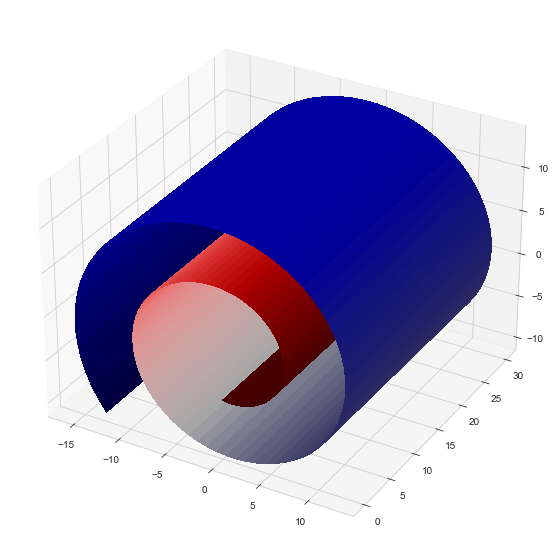

In [15]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, 
                linewidth=0, antialiased=False, 
                facecolors=cm.seismic_r(cc))

关键是，即使当大流形看起来复杂，每个点周围的局部邻域通常可以很好地近似于一片平坦的表面。换句话说，他们学习使用局部结构对全局结构进行编码。非线性降维也被称为非线性嵌入，或流形学习。非线性嵌入可有效地将高维数据压缩成低维数据。它们通常用于 2-D 或 3-D 的可视化。

然而，特征工程的目的并不是要使特征维数尽可能低，而是要达到任务的正确特征。在这一章中，正确的特征是代表数据空间特征的特征。

聚类算法通常不是局部结构化学习的技术。但事实上也可以用他们这么做。彼此接近的点（由数据科学家使用某些度量可以定义的“接近度”）属于同一个簇。给定聚类，数据点可以由其聚类成员向量来表示。如果簇的数量小于原始的特征数，则新的表示将比原始的具有更小的维度；原始数据被压缩成较低的维度。

与非线性嵌入技术相比，聚类可以产生更多的特征。但是如果最终目标是特征工程而不是可视化，那这不是问题。

我们将提出一个使用 k 均值聚类算法来进行结构化学习的思想。它简单易懂，易于实践。与非线性流体降维相反，k 均值执行非线性流形特征提取更容易解释。如果正确使用它，它可以是特征工程的一个强大的工具。

## k 均值聚类

k 均值是一种聚类算法。聚类算法根据数据在空间中的排列方式来分组数据。它们是无监督的，因为它们不需要任何类型的标签，使用算法仅基于数据本身的几何形状来推断聚类标签。

聚类算法依赖于 *度量* ，它是度量数据点之间的紧密度的测量。最流行的度量是欧几里德距离或欧几里得度量。它来自欧几里得几何学并测量两点之间的直线距离。我们对它很熟悉，因为这是我们在日常现实中看到的距离。

两个向量$X$和$Y$之间的欧几里得距离是$X-Y$的 L2 范数。（见 L2 范数的“L2 标准化”），在数学语言中，它通常被写成$‖ x - y ‖$。

k 均值建立一个硬聚类，意味着每个数据点被分配给一个且只分配一个集群。该算法学习定位聚类中心，使得每个数据点和它的聚类中心之间的欧几里德距离的总和最小化。对于那些喜欢阅读公式而非语言的人来说，目标函数是：

$$\min _{C_{1}, \ldots, C_{k}, \mu_{1}, \ldots, \mu_{k}} \sum_{i=1}^{k} \sum_{x \in C_{i}}| | x-\mu_{i}| |_{2}$$

每个簇 $C_i$ 包含数据点的子集。簇$i$的中心等于簇中所有数据点的平均值：$\mu_{i}=\sum_{x \in C_{i}} x / n_{i}$，其中 $n_i$ 表示簇$i$中的数据点的数目。

图 7-2 显示了 k 均值在两个不同的随机生成数据集上的工作。（a）中的数据是由具有相同方差但不同均值的随机高斯分布生成的。（c）中的数据是随机产生的。这些问题很容易解决，k 均值做得很好。（结果可能对簇的数目敏感，数目必须给算法）。这个例子的代码如例 7-1 所示。


### 例 7-1

In [16]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [17]:
n_data = 1000
seed = 1
n_centers = 4

# Generate random Gaussian blobs and run K-means
blobs, blob_labels = make_blobs(
    n_samples=n_data, n_features=2, centers=n_centers, random_state=seed)
clusters_blob = KMeans(
    n_clusters=n_centers, random_state=seed).fit_predict(blobs)

# Generate data uniformly at random and run K-means
uniform = np.random.rand(n_data, 2)
clusters_uniform = KMeans(
    n_clusters=n_centers, random_state=seed).fit_predict(uniform)

(-0.04972725457599163,
 1.0488815889227951,
 -0.04962977951458866,
 1.044977175970268)

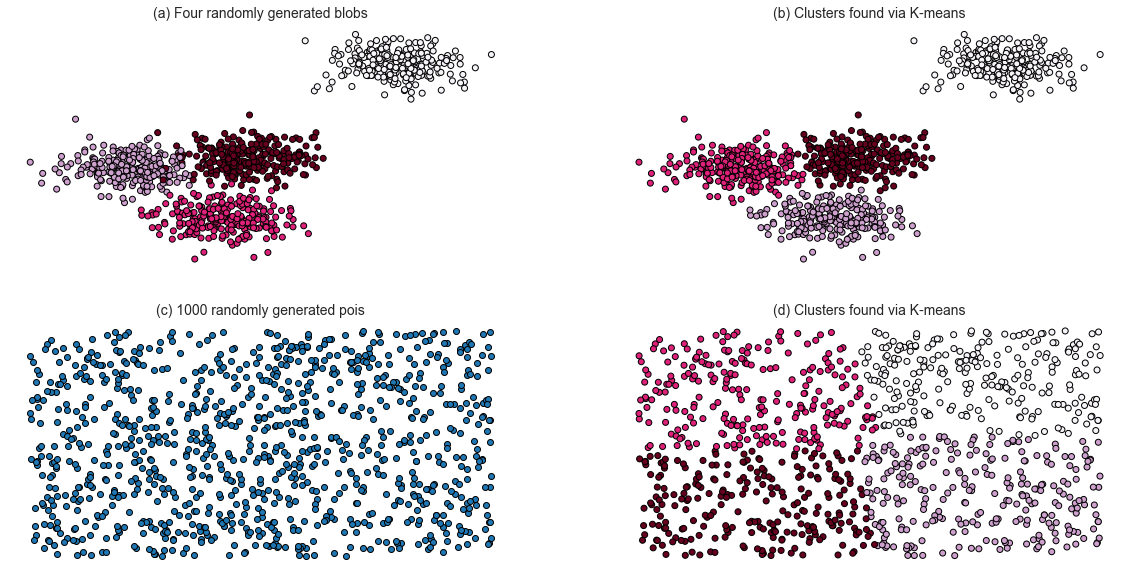

In [18]:
figure = plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.scatter(
    blobs[:, 0], blobs[:, 1], c=blob_labels, edgecolors='k', cmap='PuRd')
plt.title("(a) Four randomly generated blobs", fontsize=14)
plt.axis('off')

plt.subplot(222)
plt.scatter(
    blobs[:, 0], blobs[:, 1], c=clusters_blob, edgecolors='k', cmap='PuRd')
plt.title("(b) Clusters found via K-means", fontsize=14)
plt.axis('off')

plt.subplot(223)
plt.scatter(uniform[:, 0], uniform[:, 1], edgecolors='k')
plt.title("(c) 1000 randomly generated pois", fontsize=14)
plt.axis('off')

plt.subplot(224)
plt.scatter(
    uniform[:, 0],
    uniform[:, 1],
    c=clusters_uniform,
    edgecolors='k',
    cmap='PuRd')
plt.title("(d) Clusters found via K-means", fontsize=14)
plt.axis('off')

## 曲面拼接聚类

应用聚类一般假定存在自然簇，即在其他空的空间中存在密集的数据区域。在这些情况下，有一个正确的聚类数的概念，人们已经发明了聚类指数用于测量数据分组的质量，以便选择k。

然而，当数据像如图 7-2（c）那样均匀分布时，不再有正确的簇数。在这种情况下，聚类算法的作用是矢量量化，即将数据划分成有限数量的块。当使用量化矢量而不是原始矢量时，可以基于可接受的近似误差来选择簇的数目。

从视觉上看，k 均值的这种用法可以被认为是如图 7-3 那样用补丁覆盖数据表面。如果在瑞士卷数据集上运行 k 均值，这确实是我们所得到的。例 7-2 使用`sklearn`生成瑞士卷上的嘈杂数据集，将其用 k 均值聚类，并使用 Matplotlib 可视化聚类结果。数据点根据它们的簇 ID 着色。

![图7-3](images/chapter7/7-3.png)


### 例 7-2

In [19]:
from mpl_toolkits.mplot3d import Axes3D
# from sklearn import manifold, datasets

In [20]:
from sklearn import datasets

X, color = datasets.make_swiss_roll(n_samples=1500)

In [21]:
# 用100 K-均值聚类估计数据集 
clusters_swiss_roll = KMeans(n_clusters=100, random_state=seed).fit_predict(X)

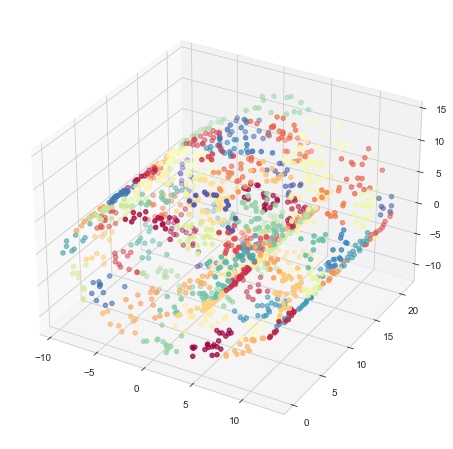

In [22]:
# 展示用数据集，其中颜色是K-均值聚类的id
fig2 = plt.figure(figsize=(10, 8))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=clusters_swiss_roll, cmap='Spectral')

图7-5

在这个例子中，我们在瑞士卷表面上随机生成 1500 个点，并要求 k 均值用 100 个簇来近似它。我们提出 100 这个数字，因为它看起来相当大，使每一簇覆盖了相当小的空间。结果看起来不错；簇群确实是很小的的，并且流体的不同部分被映射到不同的簇。不错！但我们完成了吗？

问题是，如果我们选择一个太小的$K$，那么从多元学习的角度来看，结果不会那么好。图 7-5 显示了 k 均值用 10 个簇在瑞士卷的输出。我们可以清楚地看流体的完全的部分都被映射到相同的簇（例如黄色、紫色、绿色和品红簇）的数据。

如果数据在空间中均匀分布，则选择正确的$k$就被归结为球填充问题。在$D$维中，可以拟合半径约为$R$的$1/r$的$D$次幂的球。每个 k 均值聚类是一个球面，半径是用质心表示球面中的点的最大误差。因此，如果我们愿意容忍每个数据点$R$的最大逼近误差，那么簇的数目是$O((1/R)^D)$，其中$D$是数据的原始特征空间的维数。

对于 k 均值来说，均匀分布是最坏的情况。如果数据密度不均匀，那么我们将能够用更少的簇来表示更多的数据。一般来说，很难知道数据在高维空间中是如何分布的。我们可以保守的选择更大的 K。但是它不能太大，因为`K`将成为下一步建模步骤的特征数量。

## 用于分类的 k 均值特征化

当使用 k 均值作为特征化过程时，数据点可以由它的簇成员（分类变量群组成员的稀疏独热编码）来表示，我们现在来说明。

如果目标变量也是可用的，那么我们可以选择将该信息作为对聚类过程的提示。一种合并目标信息的方法是简单地将目标变量作为 k 均值算法的附加输入特征。由于目标是最小化在所有输入维度上的总欧氏距离，所以聚类过程将试图平衡目标值和原始特征空间中的相似性。可以在聚类算法中对目标值进行缩放以获得更多或更少的关注。目标的较大差异将产生更多关注分类边界的聚类。

## k 均值特征化

聚类算法分析数据的空间分布。因此，k 均值特征化创建了一个压缩的空间索引，该数据可以在下一阶段被馈送到模型中。这是模型堆叠（stacking）的一个例子。

例 7-3 显示了一个简单的 k 均值特征。它被定义为可以训练数据和变换任何新数据的类对象。为了说明在聚类时使用和不使用目标信息之间的差异，我们将特征化器应用到使用`sklearn`的 *make——moons* 函数（例 7-4）生成的合成数据集。然后我们绘制簇边界的 Voronoi 图。图 7-6 展示出了结果的比较。底部面板显示没有目标信息训练的集群。注意，许多簇跨越两个类之间的空空间。顶部面板表明，当聚类算法被给定目标信息时，聚类边界可以沿着类边界更好地对齐。

### 例 7-3

In [23]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons
from sklearn.preprocessing import OneHotEncoder
import sklearn
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships.
    
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster. If a target variable is present, it is 
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.

    Parameters
    ----------
    k: integer, optional, default 100
        The number of clusters to group data into.

    target_scale: float, [0, infty], optional, default 5.0
        The scaling factor for the target variable. Set this to zero to ignore
        the target. For classification problems, larger `target_scale` values 
        will produce clusters that better respect the class boundary.

    random_state : integer or numpy.RandomState, optional
        This is passed to k-means as the generator used to initialize the 
        kmeans centers. If an integer is given, it fixes the seed. Defaults to 
        the global numpy random number generator.

    Attributes
    ----------
    cluster_centers_ : array, [k, n_features]
        Coordinates of cluster centers. n_features does count the target column.
    将数字型数据输入k-均值聚类.          
    在输入数据上运行k-均值并且把每个数据点设定为它的簇id. 
    如果存在目标变量，则将其缩放并包含为k-均值的输入，以导出服从分类边界以及组相似点的簇。
    """

    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder().fit(
            np.array(range(k)).reshape(-1, 1))

    def fit(self, X, y=None):
        # 在输入数据上运行k-均值，并找到中心.
        """Runs k-means on the input data and find centroids.

        If no target is given (`y` is None) then run vanilla k-means on input
        `X`. 

        If target `y` is given, then include the target (weighted by 
        `target_scale`) as an extra dimension for k-means clustering. In this 
        case, run k-means twice, first with the target, then an extra iteration
        without.

        After fitting, the attribute `cluster_centers_` are set to the k-means
        centroids in the input space represented by `X`.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            If provided, will be weighted with `target_scale` and included in 
            k-means clustering as hint.
        """
        if y is None:
            # 没有目标变量运行k-均值
            # No target variable, just do plain k-means
            km_model = KMeans(
                n_clusters=self.k, n_init=20, random_state=self.random_state)
            km_model.fit(X)

            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self
        # 有目标信息，使用合适的缩减并把输入数据输入k-均值
        # There is target information. Apply appropriate scaling and include
        # into input data to k-means
        data_with_target = np.hstack((X, y[:, np.newaxis] * self.target_scale))

        # 在数据和目标上建立预训练k-均值模型
        km_model_pretrain = KMeans(
            n_clusters=self.k, n_init=20, random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)
        #运行k-均值第二次获得簇在原始空间没有目标信息。使用预先训练中发现的质心进行初始化。
        #通过一个迭代的集群分配和质心重新计算。
        km_model = KMeans(
            n_clusters=self.k,
            init=km_model_pretrain.cluster_centers_[:, :2],
            n_init=1,
            max_iter=1)
        km_model.fit(X)

        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self

    def transform(self, X, y=None):
        # 为每个输入数据点输出最接近的簇id。
        clusters = self.km_model.predict(X)
        return self.cluster_encoder.transform(clusters.reshape(-1, 1))

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [25]:
seed = 1
training_data, training_labels = make_moons(
    n_samples=2000, noise=0.2, random_state=seed)

In [26]:
kmf_hint = KMeansFeaturizer(
    k=100, target_scale=10, random_state=seed).fit(training_data,
                                                   training_labels)
kmf_no_hint = KMeansFeaturizer(
    k=100, target_scale=0, random_state=seed).fit(training_data,
                                                  training_labels)

In [27]:
def kmeans_voronoi_plot(X, y, cluster_centers, ax):
    """Plots the Voronoi diagram of the kmeans clusters overlayed with the data"""
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', alpha=0.2)
    vor = Voronoi(cluster_centers)
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, alpha=0.5)

Text(0.5, 1.0, 'K-Means without Target Hint')

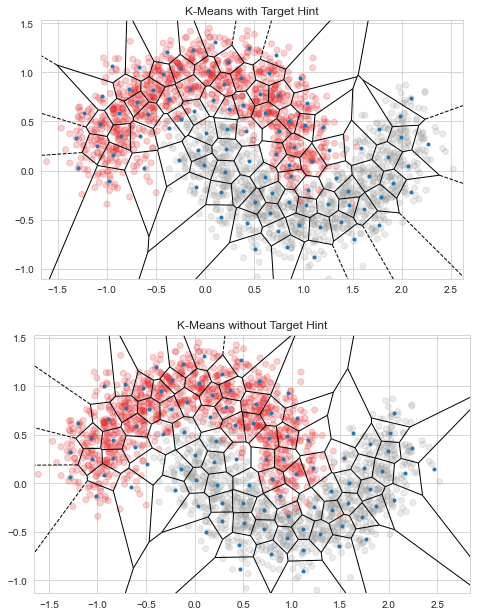

In [28]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(211, aspect='equal')
fig.tight_layout(pad=0, w_pad=4.0, h_pad=4.0)
kmeans_voronoi_plot(training_data, training_labels, kmf_hint.cluster_centers_,
                    ax)
ax.set_title('K-Means with Target Hint')
ax2 = plt.subplot(212, aspect='equal')
kmeans_voronoi_plot(training_data, training_labels,
                    kmf_no_hint.cluster_centers_, ax2)
ax2.set_title('K-Means without Target Hint')

让我们测试 k 均值特征分类的有效性。例 7-5 对 k 均值簇特征增强的输入数据应用 Logistic 回归。比较了与使用径向基核的支持向量机（RBF SVM）、K 近邻（KNN）、随机森林（RF）和梯度提升树（GBT）的结果。随机森林和梯度提升树是最流行的非线性分类器，具有最先进的性能。RBF 支持向量机是欧氏空间的一种合理的非线性分类器。KNN 根据其 K 近邻的平均值对数据进行分类。（请参阅“分类器概述”来概述每个分类器。）

分类器的默认输入数据是数据的 2D 坐标。Logistic 回归也给出了簇成员特征（在图 7-7 中标注为“k 均值的 LR”）。作为基线，我们也尝试在二维坐标（标记为“LR”）上进行逻辑回归。

### 例 7-4

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [30]:
#生成与训练数据相同分布的测试数据
test_data, test_labels = make_moons(n_samples=2000, noise=0.3)

# 使用k-均值特技器生成簇特征
training_cluster_features = kmf_hint.transform(training_data)
test_cluster_features = kmf_hint.transform(test_data)

# 将新的输入特征和聚类特征整合
training_with_cluster = scipy.sparse.hstack((training_data,
                                             training_cluster_features))
test_with_cluster = scipy.sparse.hstack((test_data, test_cluster_features))

# 建立分类器
lr_cluster = LogisticRegression(random_state=seed).fit(training_with_cluster,
                                                       training_labels)

classifier_names = ['LR', 'kNN', 'RBF SVM', 'Random Forest', 'Boosted Trees']
classifiers = [
    LogisticRegression(random_state=seed),
    KNeighborsClassifier(5),
    SVC(gamma=2, C=1, random_state=seed),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=seed),
    GradientBoostingClassifier(
        n_estimators=10, learning_rate=1.0, max_depth=5, random_state=seed)
]
for model in classifiers:
    model.fit(training_data, training_labels)

In [31]:
# 辅助函数使用ROC评估分类器性能
def test_roc(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:, 1]
    fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)
    return fpr, tpr

Text(0, 0.5, 'True Positive Rate')

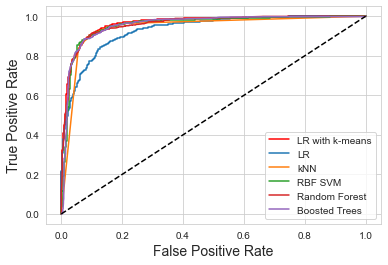

In [32]:
# 显示结果
plt.figure()
fpr_cluster, tpr_cluster = test_roc(lr_cluster, test_with_cluster, test_labels)
plt.plot(fpr_cluster, tpr_cluster, 'r-', label='LR with k-means')

for i, model in enumerate(classifiers):
    fpr, tpr = test_roc(model, test_data, test_labels)
    plt.plot(fpr, tpr, label=classifier_names[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)

## 可选择的密集化

与独热簇相反，数据点也可以由其逆距离的密集向量表示到每个聚类中心。这比简单的二值化簇保留了更多的信息，但是现在表达是密集的。这里有一个折衷方案。一个热集群成员导致一个非常轻量级的稀疏表示，但是一个可能需要较大的$K$来表示复杂形状的数据。反向距离表示是密集的，这对于建模步骤可能花费更昂贵，但是这可以需要较小的$K$。

稀疏和密集之间的折衷是只保留最接近的簇的$p$的逆距离。但是现在$P$是一个额外的超参数需要去调整。（现在你能理解为什么特征工程需要这么多的步骤吗？），天下没有免费的午餐。

## 总结

使用 k 均值将空间数据转换为模型堆叠的一个例子，其中一个模型的输入是另一个模型的输出。堆叠的另一个例子是使用决策树类型模型（随机森林或梯度提升树）的输出作为线性分类器的输入。堆叠已成为近年来越来越流行的技术。非线性分类器训练和维护是昂贵的。堆叠的关键一点是将非线性引入特征，并且使用非常简单的、通常是线性的模型作为最后一层。该特征可以离线训练，这意味着可以使用昂贵的模型，这需要更多的计算能力或内存，但产生有用的特征。顶层的简单模型可以很快地适应在线数据的变化分布。这是精度和速度之间的一个很好的折衷，这经常被应用于需要快速适应改变数据分布的应用，比如目标广告。

## 模型堆叠的关键点

复杂的基础层（通常是昂贵的模型）产生良好的（通常是非线性的）特征，随后结合简单并且快速的顶层模型。这常常在模型精度和速度之间达到正确的平衡。

与使用非线性分类器相比，采用 logistic 回归的 k 均值更容易进行训练和存储。表 7-1 是多个机器学习模型的计算和记忆的训练和预测复杂性的图表。$n$表示数据点的数量，$D$（原始）特征的数量。

对于 k 均值，训练时间是$O(nkd)$，因为每次迭代涉及计算每个数据点和每个质心（$k$）之间的$d$维距离。我们乐观地假设迭代次数不是$n$的函数，尽管并不普遍适用。预测需要计算新的数据点与质心（$k$）之间的距离，即$O(kd)$。存储空间需求是$O(kd)$，对于$K$质心的坐标。

logistic 训练和预测在数据点的数量和特征维度上都是线性的。RBF SVM 训练是昂贵的，因为它涉及计算每一对输入数据的核矩阵。RBF SVM 预测比训练成本低，在支持向量$S$和特征维数$D$的数目上是线性的。改进的树模型训练和预测在数据大小和模型的大小上线性的（$t$个树，每个最多 2 的$m$次幂子叶，其中$m$是树的最大深度）。KNN 的实现根本不需要训练时间，因为训练数据本身本质上是模型。花费全都在预测时间，输入必须对每个原始训练点进行评估，并部分排序以检索 K 近邻。

总体而言，k 均值 +LR 是在训练和预测时间上唯一的线性组合（相对于训练数据$O(nd)$的大小和模型大小$O(kd)$）。复杂度最类似于提升树，其成本在数据点的数量、特征维度和模型的大小（$O(2^m*t)$）中是线性的。很难说 k 均值 +LR 或提升树是否会产生更小的模型，这取决于数据的空间特征。

![图T7-1](images/chapter7/T7-1.png)

## 数据泄露的潜力

那些记得我们对数据泄露的谨慎（参见“防止数据泄露（桶计数：未来的日子）”）可能会问 k 均值特化步骤中的目标变量是否也会导致这样的问题。答案是“是的”，但并不像桶计数（Bin-counting）计算的那么多。如果我们使用相同的数据集来学习聚类和建立分类模型，那么关于目标的信息将泄漏到输入变量中。因此，对训练数据的精度评估可能过于乐观，但是当在保持验证集或测试集上进行评估时，偏差会消失。此外，泄漏不会像桶计数那么糟糕（参见“桶计数”），因为聚类算法的有损压缩将抽象掉一些信息。要格外小心防止泄漏，人们可以始终保留一个单独的数据集来导出簇，就像在桶计数下一样。

k 均值特化对有实数、有界的数字特征是有用的，这些特征构成空间中密集区域的团块。团块可以是任何形状，因为我们可以增加簇的数量来近似它们。（与经典的类别聚类不同，我们不关心真正的簇数；我们只需要覆盖它们。）

k 均值不能处理欧几里得距离没有意义的特征空间，也就是说，奇怪的分布式数字变量或类别变量。如果特征集包含这些变量，那么有几种处理它们的方法：

1.  仅在实值的有界数字特征上应用 k 均值特征。

2.  定义自定义度量（参见第？章以处理多个数据类型并使用 k 中心点算法。（k 中心点类似于 k 均值，但允许任意距离度量。）

3.  类别变量可以转换为装箱统计（见“桶计数”），然后使用 k 均值进行特征化。

结合处理分类变量和时间序列的技术，k 均值特化可以自适应的处理经常出现在客户营销和销售分析中的丰富数据。所得到的聚类可以被认为是用户段，这对于下一个建模步骤是非常有用的特征。

我们将在下一章中讨论的深度学习，是通过将神经网络层叠在一起，将模型堆叠提升到一个全新的水平。ImageNet 挑战的两个赢家使用了 13 层和 22 层神经网络。就像 k 均值一样，较低层次的深度学习模型是无监督的。它们利用大量可用的未标记的训练图像，并寻找产生良好图像特征的像素组合。